In [1]:
import json
import random
import numpy as np
import tensorflow as tf
from collections import deque
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras import backend as K
import convert_event_list as convert
import datetime
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import time
import math

from matplotlib.colors import LinearSegmentedColormap
import colorsys
import numpy as np
    
from data_retrieval_3ksol import INSTANCEProvider
from kbh_yard_b2b import KBH_Env                               #This is the environment of the shunting yard
from dqn_kbh_colfax_b2b_instances_test_agent import DQNAgent

Using TensorFlow backend.


In [2]:
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

In [3]:
#instances = range(5000,8020)
instances = range(5000,8020)

In [7]:
import random 
#this greedy picks the first track if multiple options are available. 

class ConsistentSmartGreedy:
    def __init__(self, yrd):
        self.action_size = yrd.nr_tracks 
        
    def get_action(self, yrd, event_list):
        track_lenghts = yrd.track_lengths
        current_track_lenght_occupation = yrd.tracks_used_length
        current_track_occupation = yrd.tracks
        event = event_list.iloc[0]
        
        if event['event_type'] == 'arrival':
            action = self.get_parking_action(track_lenghts, current_track_lenght_occupation,
                                       current_track_occupation, event)
        
        if event['event_type'] == 'departure':
            action = self.get_departure_action(track_lenghts, current_track_lenght_occupation,
                                       current_track_occupation, event)
            
        return action
    
    def get_parking_action(self, track_lengths, current_track_length_occupation, 
                           current_track_occupation, event):
        single_subtype = False
        if len(event['composition']) == 1:
            single_subtype = True
        if len(event['composition']) == 2:
            if event['composition'][0] == event['composition'][1]:
                single_subtype = True
                
        if single_subtype:
            #print("single subtype")
            # single subtype, put it behind a track that has a train of same unit type in front
            # note that this only can happen if the train would still fit!! 
            tracks_same_type_front = []
            for tracknr, occupation, length, length_occupation in zip(range(9), current_track_occupation, track_lengths, current_track_length_occupation):
                if length-length_occupation >= event['length']:
                    if len(occupation)>0:
                        if occupation[0] == event['composition'][0]:
                            tracks_same_type_front.append(tracknr)
            if len(tracks_same_type_front)>=1:
                #get first track
                action = tracks_same_type_front[-1]
                #print('put in front of same unit where it fits')
                return action
        
        #otherwise:
        #try to put it on a empty track where the train fits. 
        empty_tracks = []
        for tracknr, occupation in zip(range(9), current_track_occupation):
            if len(occupation)==0:
                empty_tracks.append(tracknr)

        possible_empty_tracks = []
        for track_nr in empty_tracks:
            if track_lengths[track_nr] >= event['length']:
                possible_empty_tracks.append(track_nr)

        if len(possible_empty_tracks)>= 1:
            #if there exist an empty track on which it fits put it there
            #put it on the first 
            action = possible_empty_tracks[-1]
            #print('put on EMPTY track that fits')
            return action

        #else pick a random track where it fits
        tracks_fit = []
        for track_nr, length, occupation in zip(range(9), track_lengths, current_track_length_occupation):
            if length-occupation >= event['length']:
                tracks_fit.append(track_nr)
        if len(tracks_fit)>0:
            #put on first track that fits 
            action = tracks_fit[-1]
            return action
        else: 
            #pick all actions will be wrong
            action = random.choice(range(9))
            #print('last action, no good choices')
            return action        

    def get_departure_action(self, track_lengths, current_track_length_occupation, 
                           current_track_occupation, event):
        requested_train = event['composition']
        #look if this train is in front of any of the tracks:
        good_tracks = []
        for track_nr, track_occ in zip(range(9), current_track_occupation):
            if len(track_occ)>0:
                if track_occ[0] == requested_train:
                    good_tracks.append(track_nr)
        
        if len(good_tracks)>0:
            #print('departure available')
            #pick first good track
            action = good_tracks[-1]
        
        else:
            #pick any action, will always be wrong:
            action = random.choice(range(9))
        
        return action
            
    
# event_list = ig.get_instance(instance)
# state = yrd.reset(event_list)

# GA = GreedyAgent(yrd)
# GA.get_action(yrd, event_list)
        
        
        

Number of labels: 200
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
Greedy:
   original_length  solved  tried  percentage
0               23     299    755    0.396026
1               26     283    755    0.374834
2               27     312    755    0.413245
3               29     279    755    0.369536


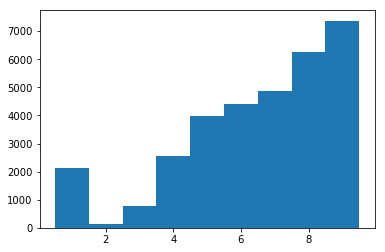

In [15]:
#Evaluate consistent smarter greedy 
#This one is included in the paper. 

#LOAD THE INSTANCE PROVIDER
ig = INSTANCEProvider()

# Create environment KBH
yrd = KBH_Env()

# Create the Greedy Agent
agent = ConsistentSmartGreedy(yrd)

new_cmap = rand_cmap(200, type='soft', first_color_black=True, last_color_black=False, verbose=True)

visualization = False

n = len(instances)

# result vectors
original_lengths = []
terminated_at_step = []
print_count = 0

# train types different tracks? 
type_step_track = []

for instance in instances:
    if print_count % 100 == 0:
        print(print_count)
    print_count = print_count + 1
    #Initialize problem
    event_list = ig.get_instance(instance)

    steps = len(event_list)
    if len(event_list) < 60:        
        t = 0

        score = 0  # Init score variable for this particular episode.

        state = yrd.reset(event_list)  # Get first observation based on the first train arrival.
        history = np.reshape(state, (
            1, yrd.shape[0], yrd.shape[1], yrd.shape[2]))  # reshape state into tensor, which we call history.

        if visualization == True:
            plt.imshow(np.float32(history[0][0]), cmap=new_cmap, interpolation='nearest')
            plt.show()

        while t <= steps:
            action = agent.get_action(yrd, event_list)  # RL choose action based on observation

            if visualization == True:
                print('Action: ' + str(action+1))
            # RL take action and get next observation and reward
            # note the +1 at action
            event_list_temp = event_list.reset_index(drop=True).copy()
            if event_list_temp.event_type[0]=='arrival':
                train_type = event_list_temp.composition[0]
                type_step_track.append({'type': train_type, 'action': action+1, 'step':t, 'instance_id': instance})

            raw_observation_, reward, done = yrd.step(action + 1, event_list)

            state_ = np.reshape(raw_observation_, (1, yrd.shape[0], yrd.shape[1], yrd.shape[2]))  # reshape to tensor.
            history_ = state_  # this is now the next observation, call it history_

            score += reward  # log direct reward of action

            if visualization == True: 
                #show action
                plt.imshow(np.float32(history_[0][0]), cmap=new_cmap, interpolation='nearest')
                plt.show()
                time.sleep(0.05)
                if reward == -1:
                    time.sleep(1)
                print(reward)

            if done:  # based on what the environment returns.
                #print('ended at step' , t+1)
                #print('original length', steps)
                original_lengths.append(steps)
                terminated_at_step.append(t+1)
                break;

            history = history_  # next state now becomes the current state.
            t += 1  # next step in this episode
    else: 
        original_lengths.append(steps)
        terminated_at_step.append(-1)

#compute scores
df_type_step_track = pd.DataFrame.from_records(type_step_track)
df_type_step_track['strtype'] = df_type_step_track.apply(lambda row: str(row.type), axis = 1)
df_type_step_track.strtype = df_type_step_track.strtype.astype('category')

analysis_runs = pd.DataFrame(
{'instance_id': instances,
 'original_length': original_lengths,
 'terminated_at_step': terminated_at_step
})

analysis_runs['solved'] = analysis_runs.apply(lambda row: 1 if row.original_length == row.terminated_at_step else 0, axis =1 )
analysis_runs['tried'] = analysis_runs.apply(lambda row: 1 if row.terminated_at_step != -1 else 0, axis =1)
analysis_runs['percentage'] = analysis_runs.apply(lambda row: row.solved/755, axis=1)

print('Greedy:')
summary = analysis_runs.groupby('original_length', as_index=False)[['solved', 'tried', 'percentage']].sum()
print(summary)

#print hist
%matplotlib inline  
#%%
# analyse the parking actions per step and train type
df_type_step_track = pd.DataFrame.from_records(type_step_track)
bins = [1,2,3,4,5,6,7,8,9,10]
plt.hist(df_type_step_track.action, bins, align='left')


#prepare for save
df_type_step_track['strtype'] = df_type_step_track.apply(lambda row: str(row.type), axis = 1)
df_type_step_track.strtype = df_type_step_track.strtype.astype('category')
filename = 'data_consistent_greedy_paper.csv'
df_type_step_track.to_csv(filename)

analysis_runs.to_csv('greedy_consistent_solved_instances.csv')





